# Logistic Regression: Red Clump Star Classification

- By Yuan-Sen Ting, February 2025, for Astron 5550

In this tutorial, we'll explore the application of logistic regression for distinguishing Red Clump (RC) stars from Red Giant Branch (RGB) stars. We'll walk through the step-by-step process of building, training, evaluating, and interpreting a logistic regression model, building on concepts from our previous linear regression tutorial.

## Learning Objectives

By working through this RC/RGB classification problem, you'll gain an understanding of logistic regression.  By the end of this tutorial, you will be able to:

-   Adapt linear models for binary classification using the sigmoid function.
-   Implement gradient-based optimization (specifically, mini-batch gradient descent) from scratch.
-   Evaluate classifier performance using appropriate metrics (accuracy, balanced accuracy, and confusion matrices).
-   Interpret the learned parameters of a logistic regression model.
- Understand the concept of hyperparameter and perform hyperparameter tuning.

## Prerequisites

This tutorial assumes familiarity with:

-   Basic Python programming.
-   Concepts from our previous linear regression tutorials.
-   The fundamental idea of logistic regression (transforming a linear output to a probability).
-   Basic gradient descent optimization.

## Setup

First, we set up our Python environment:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

# Set plotting parameters for better visualization
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# Set a smaller figure size
plt.rcParams['figure.figsize'] = (6, 4)

# For reproducibility
np.random.seed(42)

## The Astronomical Context: Red Clump Stars as Standard Candles

In Galactic archaeology, accurate distance measurements are paramount. While the Gaia satellite provides precise parallax measurements for nearby stars, its uncertainty increases quadratically with distance, limiting its reach.  Red Clump (RC) stars offer a solution.

RC stars are valuable "standard candles" because they have a remarkably consistent intrinsic brightness, regardless of their age or chemical composition.  This is analogous to knowing the wattage of a lightbulb; if you know the intrinsic brightness, you can determine the distance by measuring the apparent brightness.  If we can reliably identify RC stars, we can use their apparent magnitudes to measure distances, with uncertainties that scale linearly rather than quadratically, extending our reach much further into the Galaxy.

Traditionally, astronomers use asteroseismology (the study of stellar oscillations) to distinguish RC stars from Red Giant Branch (RGB) stars.  The internal structure of a star affects its oscillation patterns, and RC stars have a distinct internal structure due to helium core burning.  However, obtaining high-quality asteroseismic data (e.g., from Kepler or TESS) is challenging for large-scale surveys due to limited sky coverage and signal-to-noise constraints for fainter or more distant stars.

Fortunately, the transition from the RGB phase (hydrogen shell burning) to the RC phase (helium core burning) causes subtle but measurable changes in stellar properties like surface gravity and effective temperature.  Spectroscopic measurements, which analyze the light emitted by stars at different wavelengths, are sensitive to these physical conditions.

Our dataset, derived from the APOGEE spectroscopic survey, includes measurements of temperature, gravity, metallicity, and other parameters, along with asteroseismic classifications (the "ground truth" labels).  Let's load the data:

In [2]:
# Load the dataset
data = np.load("dataset_apogee_asteroseismic.npz")
X = data["data"]  # Feature matrix
t = data["label"]  # Labels (1 for RC, 0 for RGB)

print("Dataset Overview:")
print(f"Number of stars: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of RC stars: {np.sum(t == 1)}")
print(f"Number of RGB stars: {np.sum(t == 0)}")

Dataset Overview:
Number of stars: 2855
Number of features: 8
Number of RC stars: 2125
Number of RGB stars: 730


Our APOGEE dataset contains spectroscopic measurements for 2855 stars, each described by eight features:

1.  Effective temperature (Teff)
2.  Surface gravity (log g)
3.  Metallicity ([Fe/H])
4.  Right Ascension (RA)
5.  Declination (Dec)
6.  J-band magnitude
7.  H-band magnitude
8.  K-band magnitude

The first three describe the star's physical state; the others provide positional and brightness information. The labels (0 or 1) were determined by asteroseismic analysis, indicating whether each star is RGB (0) or RC (1).

Let's visualize the data in the temperature-gravity plane, a standard diagram in stellar astrophysics:

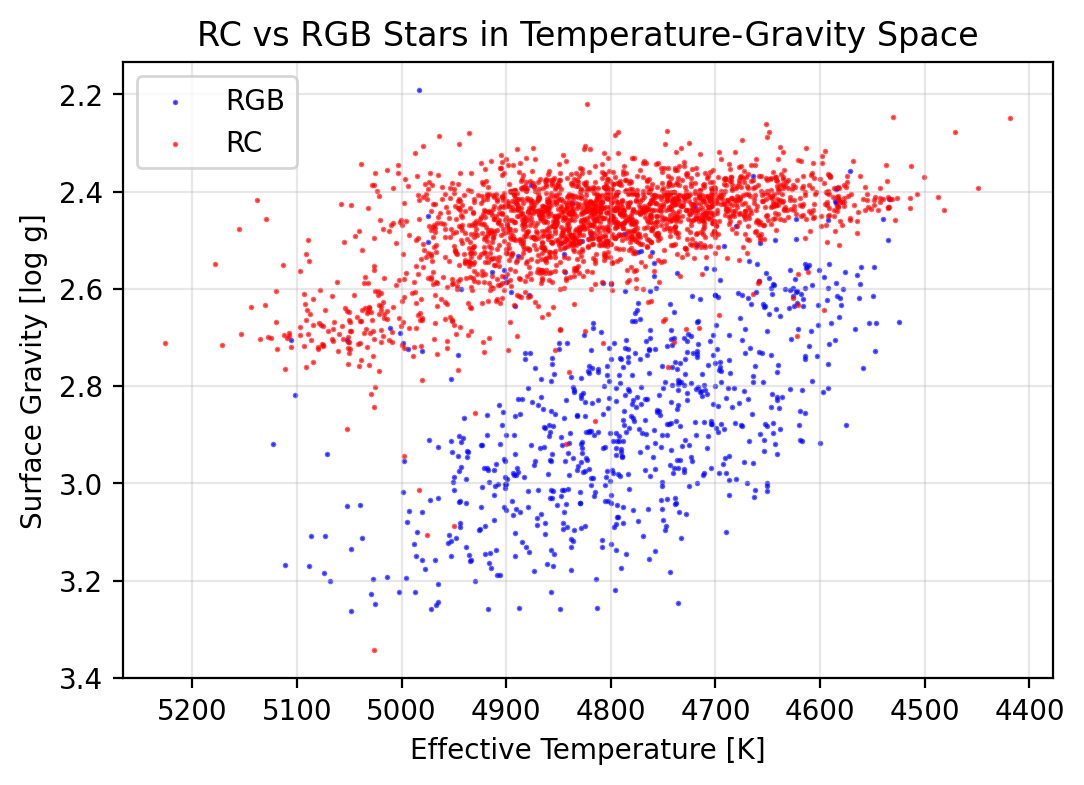

In [3]:
# Plot RGB stars (label = 0) in blue
plt.scatter(X[t == 0, 0], X[t == 0, 1], c='b', s=1, alpha=0.6, label='RGB')
# Plot Red Clump stars (label = 1) in red
plt.scatter(X[t == 1, 0], X[t == 1, 1], c='r', s=1, alpha=0.6, label='RC')

# Customize the plot
plt.gca().invert_xaxis()  
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('RC vs RGB Stars in Temperature-Gravity Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The temperature-gravity diagram shows a clear separation between RC and RGB stars, although there's some overlap. RC stars cluster tightly, reflecting their consistent evolutionary state (helium core burning). RGB stars, still burning hydrogen in a shell, are more spread out. This visual separation suggests that logistic regression should be effective.



## From Linear to Logistic Regression

In our previous tutorials, we used linear regression to predict continuous values.  Here, we have a binary classification problem: is a star RC or RGB? Linear regression is unsuitable because it can output any real number, whereas we need a probability between 0 and 1.

Logistic regression solves this by applying the sigmoid function (also called the logistic function) to the output of a linear model:

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

This function "squashes" any real number into the range (0, 1), making it suitable for representing probabilities.  The model's prediction for the probability of a star being RC, given its features $\mathbf{x}$, is:

$$ P(t=1|\mathbf{x}, \mathbf{w}) = \sigma(\mathbf{w}^T\mathbf{x}) $$

where $\mathbf{w}$ are the model weights (parameters) that we'll learn from the data. Notice how this is just the linear model ($\mathbf{w}^T\mathbf{x}$) with the sigmoid applied.

Let's visualize the sigmoid function:

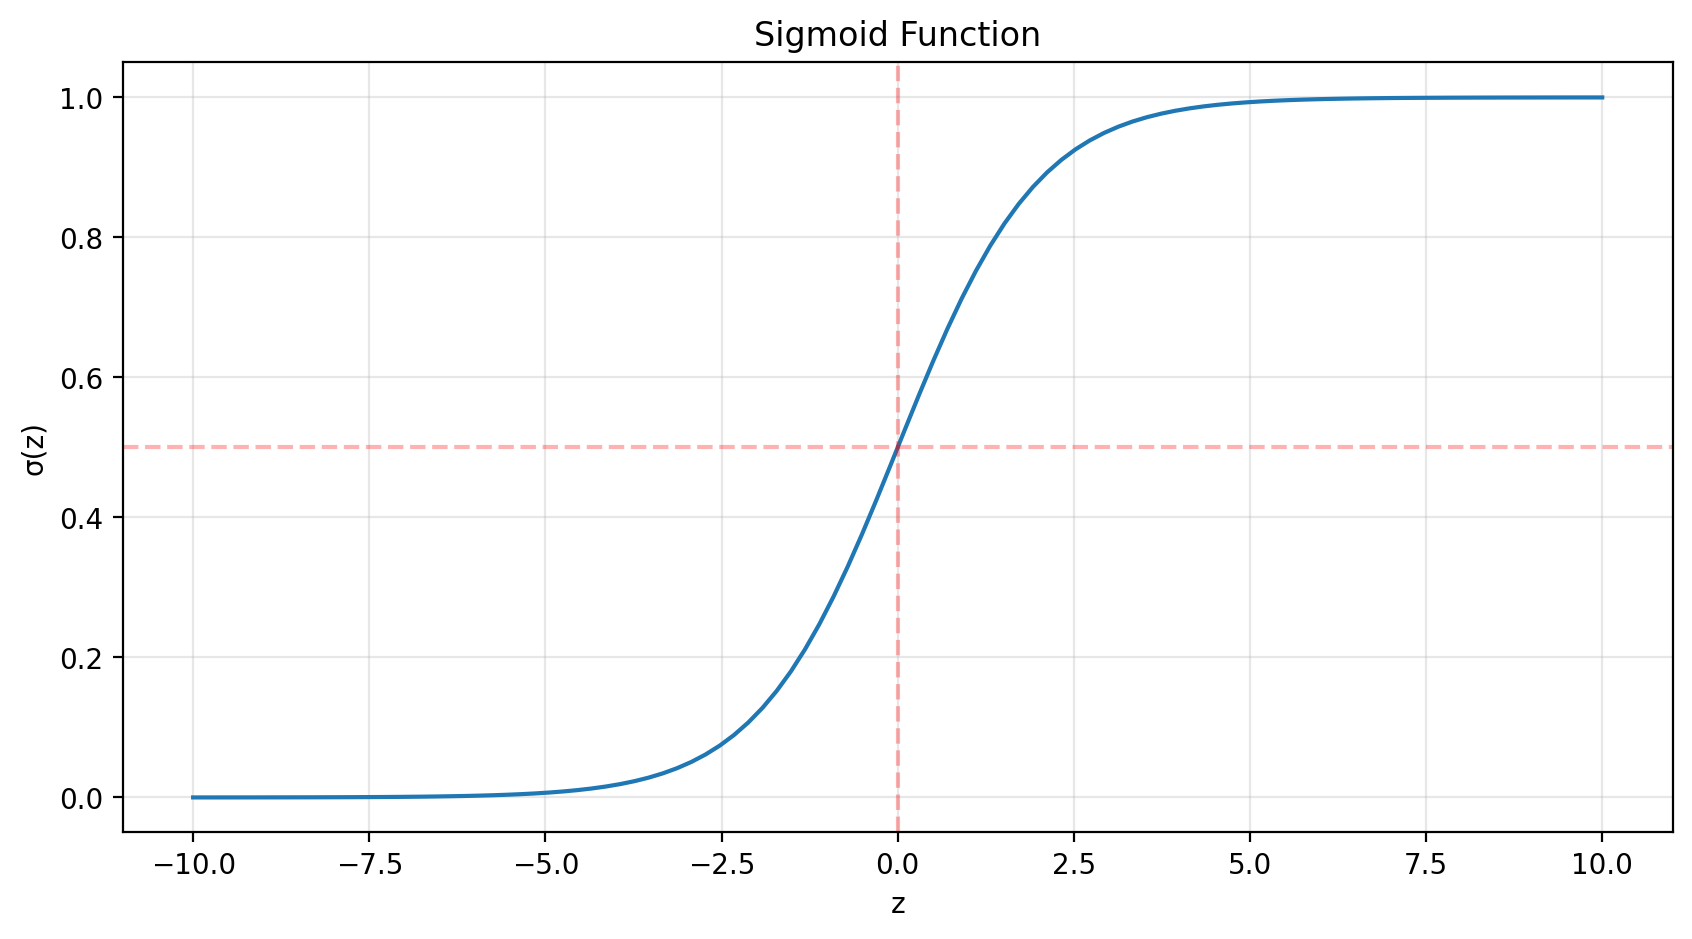

In [4]:
def sigmoid(z):
    """Transform input to probability using sigmoid function."""
    return 1 / (1 + np.exp(-z))

# Demonstrate sigmoid function
z = np.linspace(-10, 10, 100)
plt.figure(figsize=(10, 5))
plt.plot(z, sigmoid(z))
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.title('Sigmoid Function')
plt.show()

The sigmoid function is S-shaped.  When $z$ is large and positive, $\sigma(z)$ approaches 1; when $z$ is large and negative, $\sigma(z)$ approaches 0.  When $z=0$, $\sigma(z) = 0.5$.  This is the core of how logistic regression transforms a linear model into a classifier.

## Model Formulation and Maximum Likelihood

For a star with features  $\mathbf{x}$, our logistic regression model predicts the probability of it being an RC star (t=1) as:

$$ p(t=1 | \mathbf{x}, \mathbf{w}) = \sigma(\mathbf{w}^T \mathbf{x}) $$

where $\mathbf{w}$ is the vector of weights we need to learn.  Instead of minimizing the squared error (as in linear regression), we maximize the likelihood of observing our training data.

For a single star, the likelihood of observing its label $t$ (which is either 0 or 1) is:

$$ p(t | \mathbf{x}, \mathbf{w}) = y^t (1 - y)^{(1 - t)} $$

where $y = \sigma(\mathbf{w}^T \mathbf{x})$ is our model's predicted probability.  This formula might look complex, but it's quite elegant:

-   If $t = 1$ (the star is RC), the likelihood is simply $y$ (the predicted probability of being RC).
-   If $t = 0$ (the star is RGB), the likelihood is $1 - y$ (the predicted probability of not being RC).

To find the best weights $\mathbf{w}$, we maximize the product of these likelihoods for all stars in our training set.  It's mathematically equivalent (and numerically more stable) to maximize the log-likelihood, or equivalently, to minimize the negative log-likelihood:

$$ E(\mathbf{w}) = -\sum_{n=1}^N [t_n \log(y_n) + (1 - t_n) \log(1 - y_n)] $$

where $N$ is the number of stars, $t_n$ is the true label of the $n$-th star, and $y_n = \sigma(\mathbf{w}^T \mathbf{x}_n)$ is the model's prediction for that star. This is our cost function.

Let's implement this cost function in Python:

In [5]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

def cost(w, X, t, N):
    """Negative log-likelihood cost function."""
    z = X @ w
    y = sigmoid(z)
    return -np.sum(t * np.log(y + 1e-15) +
                  (1 - t) * np.log(1 - y + 1e-15)) / N

# Normalize features and add bias term
# Save the mean and standard deviation before normalizing
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

# Normalize the features
X_norm = (X - X_mean) / X_std
X_norm = np.hstack((np.ones((len(t), 1)), X_norm))

# Compute initial cost with zero weights
w_init = np.random.randn(X_norm.shape[1])
initial_cost = cost(w_init, X_norm, t, len(t))
print(f"Initial cost: {initial_cost:.3f}")

Initial cost: 1.539


We add a small constant (`1e-15`) inside the logarithms to avoid taking the log of zero, which would lead to numerical errors.  We also normalize our features (subtract the mean and divide by the standard deviation) and add a bias term (a column of ones) to `X_norm`. This is good practice for numerical stability and faster convergence.

To minimize the cost function, we'll use gradient descent.  The gradient of the cost function with respect to the weights is:

$$ \nabla E(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^N (y_n - t_n) \mathbf{x}_n $$

This gradient has a remarkably simple and intuitive form: it's the average, over all stars, of the difference between the predicted probability ($y_n$) and the true label ($t_n$), multiplied by the feature vector ($\mathbf{x}_n$).  This means we update each weight in proportion to the prediction error, scaled by the corresponding feature value.

Here's the gradient descent implementation:

Training set size: 2284
Test set size: 571
Training set class distribution: [ 584 1700]
Test set class distribution: [146 425]
Iter     0 | Train Cost 1.162 | Test Cost 1.178
Iter    10 | Train Cost 0.894 | Test Cost 0.912
Iter    20 | Train Cost 0.682 | Test Cost 0.703
Iter    30 | Train Cost 0.525 | Test Cost 0.548
Iter    40 | Train Cost 0.416 | Test Cost 0.438
Iter    50 | Train Cost 0.341 | Test Cost 0.364
Iter    60 | Train Cost 0.291 | Test Cost 0.313
Iter    70 | Train Cost 0.256 | Test Cost 0.277
Iter    80 | Train Cost 0.231 | Test Cost 0.251
Iter    90 | Train Cost 0.212 | Test Cost 0.232
Iter   100 | Train Cost 0.197 | Test Cost 0.216
Iter   110 | Train Cost 0.186 | Test Cost 0.204
Iter   120 | Train Cost 0.177 | Test Cost 0.195
Iter   130 | Train Cost 0.169 | Test Cost 0.187
Iter   140 | Train Cost 0.163 | Test Cost 0.180
Iter   150 | Train Cost 0.157 | Test Cost 0.174
Iter   160 | Train Cost 0.152 | Test Cost 0.169
Iter   170 | Train Cost 0.148 | Test Cost 0.164
Iter   18

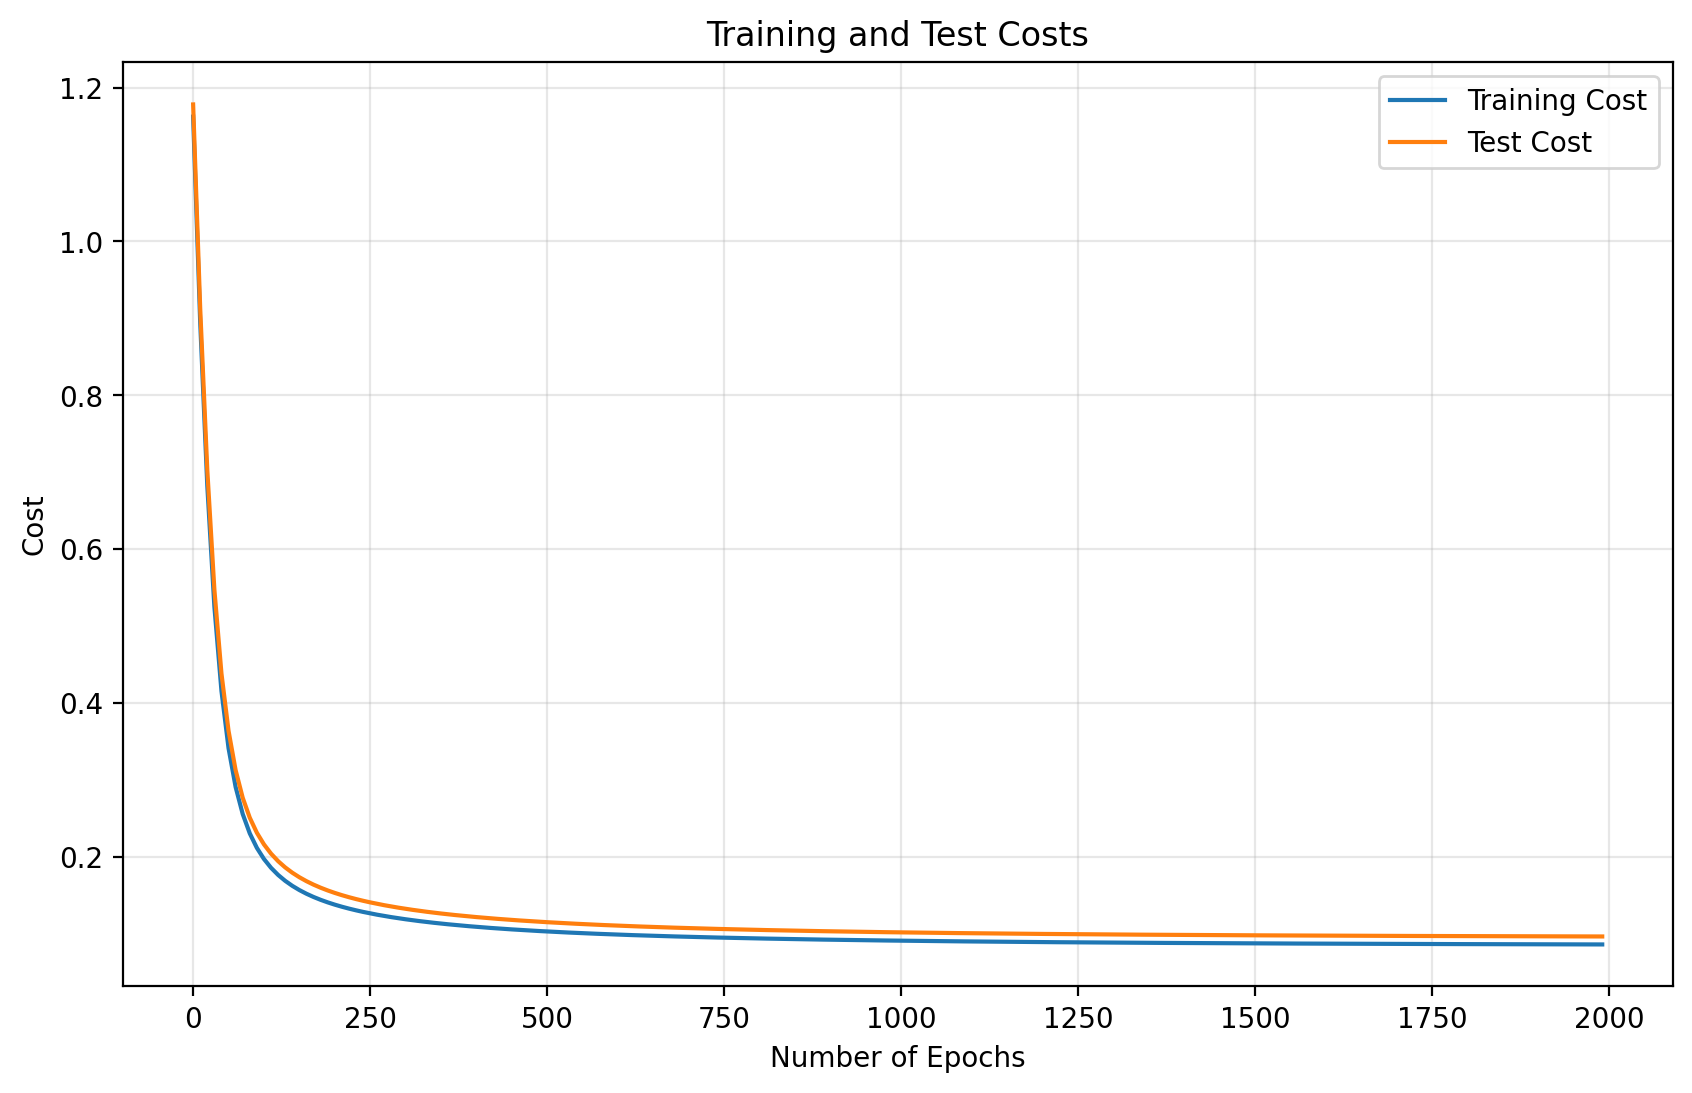


Trained weights:
[ 2.05585514  2.03991901 -4.20771551  1.37539379 -0.01552573  0.14331597
 -0.41533322 -0.78674868  0.54032977]
Training loss: 0.086
Testing loss: 0.097


In [6]:
def grad(w, X, t, N):
    """Gradient of negative log-likelihood."""
    z = X @ w
    y = sigmoid(z)
    return X.T @ (y - t) / N

def train(X, t, X_test, t_test, lr=0.1, iters=2000):
    """Train logistic regression model using batch gradient descent."""
    # Initialize weights randomly
    w = np.random.randn(X.shape[1])
    
    # Track costs for analysis
    train_costs = []
    test_costs = []

    for i in range(iters):
        # Compute gradient and update weights
        w -= lr * grad(w, X, t, len(t))

        if i % 10 == 0:
            train_cost = cost(w, X, t, len(t))
            test_cost = cost(w, X_test, t_test, len(t_test))
            train_costs.append(train_cost)
            test_costs.append(test_cost)
            print(f"Iter {i:5d} | Train Cost {train_cost:.3f} | Test Cost {test_cost:.3f}")

    # Plot training and test costs
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, iters, 10), train_costs, label='Training Cost')
    plt.plot(range(0, iters, 10), test_costs, label='Test Cost')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Cost')
    
    # add grid
    plt.grid(True, alpha=0.3)

    plt.title('Training and Test Costs')
    plt.legend()
    plt.show()
    
    return w

# Split data into training and test sets with stratification to maintain class balance
from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test = train_test_split(
    X_norm, t, test_size=0.2, random_state=46, stratify=t
)

print(f"Training set size: {len(t_train)}")
print(f"Test set size: {len(t_test)}")

# Check class distribution in both sets
print(f"Training set class distribution: {np.bincount(t_train.astype(int))}")
print(f"Test set class distribution: {np.bincount(t_test.astype(int))}")

# Train the model on training data
w_trained = train(X_train, t_train, X_test, t_test)

# Calculate and print training and test loss
train_loss = cost(w_trained, X_train, t_train, len(t_train))
test_loss = cost(w_trained, X_test, t_test, len(t_test))

print(f"\nTrained weights:\n{w_trained}")
print(f"Training loss: {train_loss:.3f}")
print(f"Testing loss: {test_loss:.3f}")


We initialize the weights with small random values from a normal distribution, which is a better strategy than zero initialization as it breaks symmetry and helps the model learn diverse features. The `lr` parameter (learning rate) controls how large a step we take in each iteration when we subtract a scaled version of the gradient. 

We print the cost every 10 iterations to monitor the training progress. This implementation uses batch gradient descent, meaning it uses the entire dataset to compute the gradient at each step. Additionally, we track both training and testing loss throughout the optimization process, allowing us to monitor how well the model generalizes to unseen data and detect potential overfitting.

## Training with Mini-batch Gradient Descent
  
Now we'll train our model using mini-batch gradient descent. Instead of using the entire training set to compute the gradient at each step (as in full-batch SGD), we'll use small, randomly chosen subsets (mini-batches).
 
-   **Full-batch SGD:** Uses the entire dataset; provides the most accurate gradient estimate but can be slow for large datasets.
-   **Mini-batch SGD:** Uses small batches of data; offers a good balance of speed and accuracy.
  
The randomness introduced by using mini-batches can also help the optimization process escape shallow local minima. 

Mini-batch gradient descent typically converges faster than full-batch gradient descent because the weights are updated after each mini-batch rather than after seeing the entire dataset, the model makes progress more rapidly. The stochasticity from sampling different mini-batches acts as a form of regularization, helping the model avoid getting stuck in poor local minima.

In the plots below, we'll see how mini-batch gradient descent typically reaches lower loss values in fewer epochs compared to full-batch methods.

Here's the mini-batch gradient descent training code:

Epoch 0: Training Loss = 0.4100, Testing Loss = 0.4352
Epoch 20: Training Loss = 0.0883, Testing Loss = 0.0986
Epoch 40: Training Loss = 0.0855, Testing Loss = 0.0959
Epoch 60: Training Loss = 0.0850, Testing Loss = 0.0953
Epoch 80: Training Loss = 0.0850, Testing Loss = 0.0955
Epoch 100: Training Loss = 0.0849, Testing Loss = 0.0954
Epoch 120: Training Loss = 0.0849, Testing Loss = 0.0953
Epoch 140: Training Loss = 0.0849, Testing Loss = 0.0955
Epoch 160: Training Loss = 0.0849, Testing Loss = 0.0954
Epoch 180: Training Loss = 0.0849, Testing Loss = 0.0954


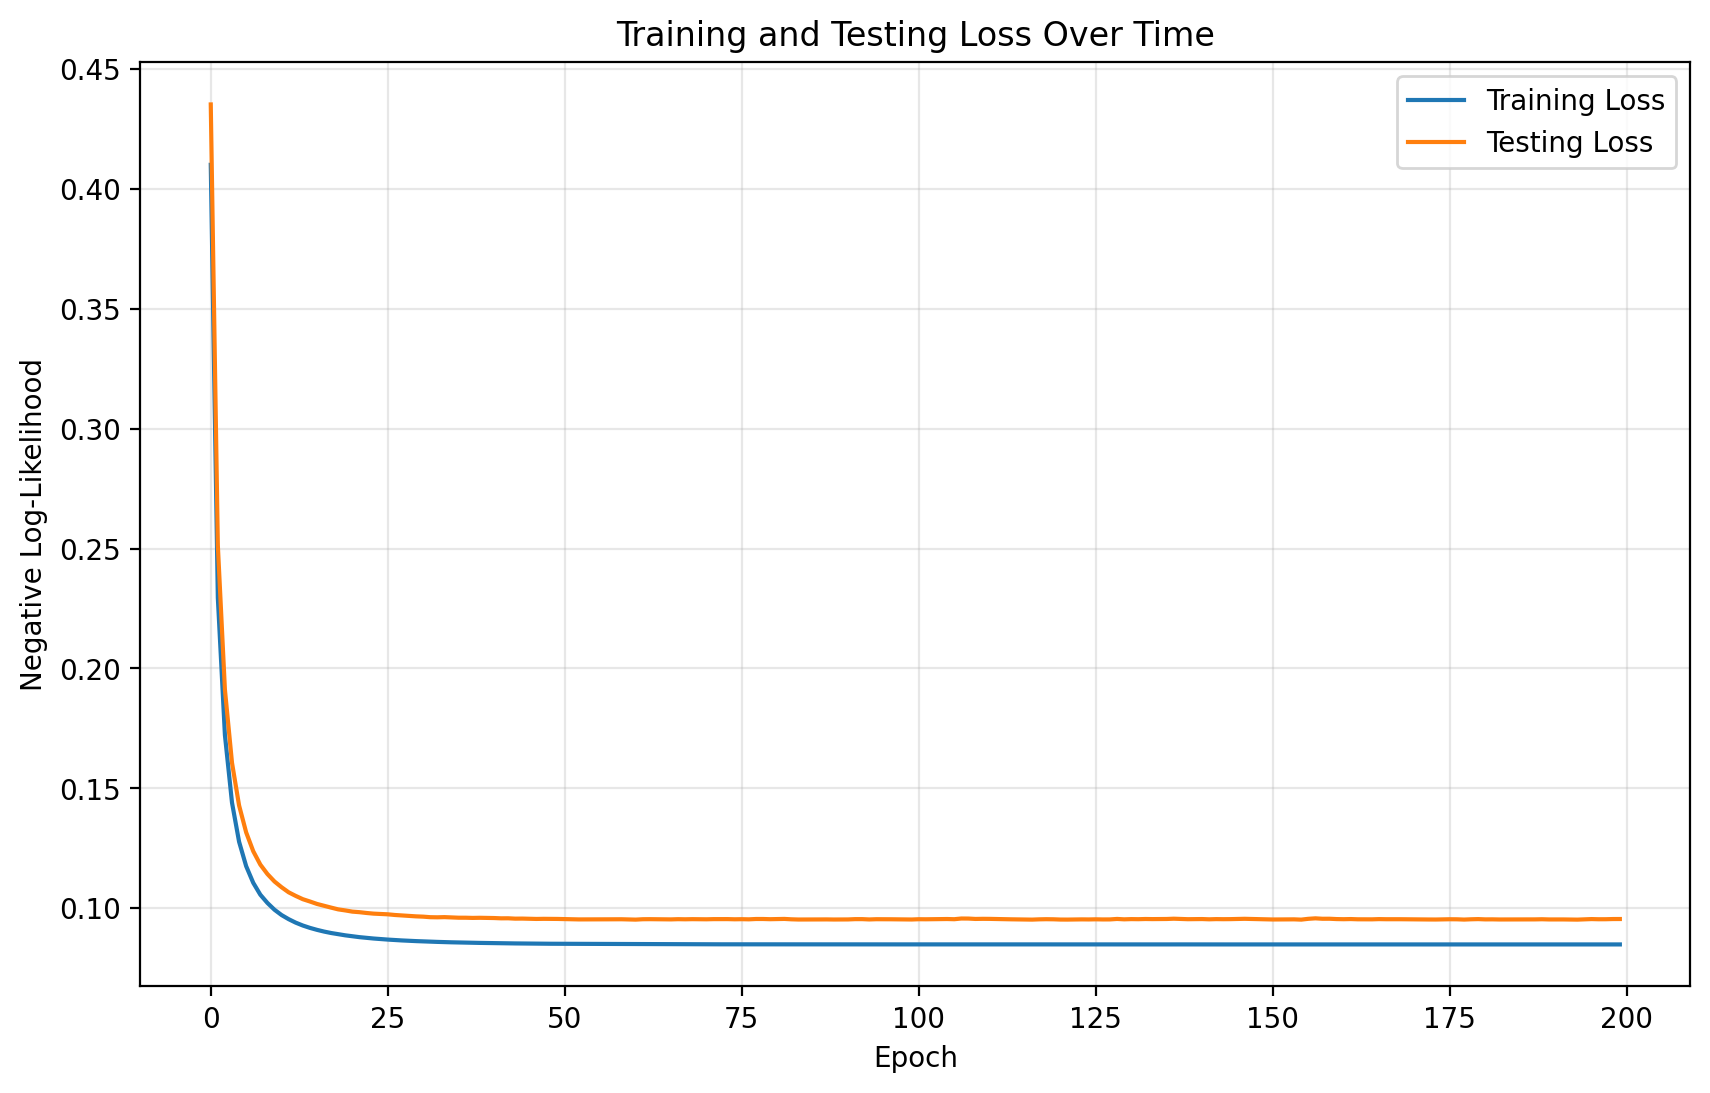

In [7]:
def create_mini_batches(X, t, batch_size):
    """Create mini-batches from data."""
    indices = np.random.permutation(len(t))
    n_batches = len(t) // batch_size

    mini_batches = []
    for i in range(n_batches):
        batch_indices = indices[i * batch_size : (i + 1) * batch_size]
        mini_batches.append((X[batch_indices], t[batch_indices]))

    #Handle the case where len(t) is not a multiple of batch_size
    if len(t) % batch_size != 0:
        batch_indices = indices[n_batches* batch_size:]
        mini_batches.append((X[batch_indices], t[batch_indices]))

    return mini_batches

def train(X_train, t_train, X_test, t_test, learning_rate, n_epochs, batch_size, grad_func):
    """
    Train logistic regression model using mini-batch gradient descent.
    """
    N, M = X_train.shape
    w = np.random.normal(0, 1, M)  # Initialize weights from a unit Gaussian distribution
    train_loss_history = []
    test_loss_history = []

    for epoch in range(n_epochs):
        mini_batches = create_mini_batches(X_train, t_train, batch_size)

        for X_batch, t_batch in mini_batches:
            grad_val = grad_func(w, X_batch, t_batch, len(t_batch))
            w = w - learning_rate * grad_val

        # Track both training and testing loss every epoch
        train_loss = cost(w, X_train, t_train, len(t_train))
        test_loss = cost(w, X_test, t_test, len(t_test))
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Training Loss = {train_loss:.4f}, Testing Loss = {test_loss:.4f}")

    return w, train_loss_history, test_loss_history

# Train model with initial hyperparameters
learning_rate = 0.1
n_epochs = 200
batch_size = 32

w_trained, train_loss_history, test_loss_history = train(
    X_train, t_train, X_test, t_test, learning_rate, n_epochs, batch_size, grad
)

# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training and Testing Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Model Evaluation
 
To evaluate our logistic regression model's performance on new, unseen data, we'll calculate the following key metrics on our test set:

1. **Accuracy**: The overall fraction of correct predictions, which tells us how often our model is right:
$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

2. **Balanced Accuracy**: A more nuanced metric that accounts for class imbalance between RC and RGB stars:
$$\text{Balanced Accuracy} = \frac{\text{Sensitivity} + \text{Specificity}}{2}$$

We'll also examine the **Confusion Matrix** to understand our model's specific strengths and weaknesses:

|               | Predicted RGB | Predicted RC |
| :------------ | :------------ | :----------- |
| **Actual RGB** | TN            | FP           |
| **Actual RC**  | FN            | TP           |

This is particularly important because:
- False Positives (FP) could lead to incorrect distance measurements
- False Negatives (FN) reduce our sample of standard candles
- The natural imbalance between RC and RGB stars in stellar populations makes balanced accuracy especially relevant

Let's calculate these metrics:

In [8]:
def predict(w, X, threshold=0.5):
    """Make predictions using trained weights."""
    z = np.dot(X, w)
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    return predictions, probabilities

def compute_metrics(t_true, t_pred):
    """Compute classification metrics."""
    TP = np.sum((t_true == 1) & (t_pred == 1))
    TN = np.sum((t_true == 0) & (t_pred == 0))
    FP = np.sum((t_true == 0) & (t_pred == 1))
    FN = np.sum((t_true == 1) & (t_pred == 0))

    accuracy = (TP + TN) / len(t_true)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    balanced_acc = (sensitivity + specificity) / 2

    return {
        'confusion_matrix': [[TN, FN], [FP, TP]],
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc
    }

# Evaluate on test set
test_pred, test_probs = predict(w_trained, X_test)
metrics = compute_metrics(t_test, test_pred)

print("Test Set Performance:")
print(f"Accuracy: {metrics['accuracy']:.3f}")
print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.3f}")
print("\nConfusion Matrix:")
cm = metrics['confusion_matrix']
print(f"True Negative (RGB): {cm[0][0]}")
print(f"False Negative (Missed RC): {cm[0][1]}")
print(f"False Positive (False RC): {cm[1][0]}")
print(f"True Positive (RC): {cm[1][1]}")

Test Set Performance:
Accuracy: 0.974
Balanced Accuracy: 0.960

Confusion Matrix:
True Negative (RGB): 136
False Negative (Missed RC): 5
False Positive (False RC): 10
True Positive (RC): 420


The `predict` function now returns both the predicted class labels (0 or 1) and the predicted probabilities. The `compute_metrics` function calculates all the metrics we need. We print the results for the test set.

## Hyperparameter Optimization

Now let's tune the hyperparameters of our model: the learning rate and the batch size.  These are parameters that are not learned during training (unlike the weights $\mathbf{w}$), but they significantly affect the training process and the final model's performance.

We'll use a grid search to systematically try different combinations of learning rates and batch sizes.  For each combination, we'll train a model and evaluate its balanced accuracy on the test set.  We'll then choose the combination that gives the best performance.

In [9]:
# Define hyperparameter grid
learning_rate_options = [0.001, 0.01, 0.1, 0.5]
batch_size_options = [16, 32, 64, 128, 256]

# Store results
balanced_accuracy_results = {}
best_balanced_acc = 0
best_lr = None
best_batch_size = None

print("Performing grid search...")
for lr in learning_rate_options:
    for batch_size in batch_size_options:
        print(f"\nTesting lr={lr}, batch_size={batch_size}")

        # Train model with current hyperparameters
        # The train function requires X_test and t_test as parameters
        w_current, train_loss_history, test_loss_history = train(
            X_train, t_train, X_test, t_test, lr, n_epochs, batch_size, grad
        )

        # Evaluate on test set
        t_test_pred, _ = predict(w_current, X_test)
        metrics = compute_metrics(t_test, t_test_pred)
        balanced_acc = metrics['balanced_accuracy']

        # Store results
        balanced_accuracy_results[(lr, batch_size)] = balanced_acc

        if balanced_acc > best_balanced_acc:
            best_balanced_acc = balanced_acc
            best_lr = lr
            best_batch_size = batch_size
            best_weights = w_current

        print(f"Balanced Accuracy: {balanced_acc:.3f}")

print(f"\nBest configuration:")
print(f"Learning Rate = {best_lr}")
print(f"Batch size = {best_batch_size}")
print(f"Balanced Accuracy = {best_balanced_acc:.3f}")

Performing grid search...

Testing lr=0.001, batch_size=16
Epoch 0: Training Loss = 1.1420, Testing Loss = 1.1542
Epoch 20: Training Loss = 0.5630, Testing Loss = 0.5915
Epoch 40: Training Loss = 0.3438, Testing Loss = 0.3729
Epoch 60: Training Loss = 0.2577, Testing Loss = 0.2835
Epoch 80: Training Loss = 0.2141, Testing Loss = 0.2373
Epoch 100: Training Loss = 0.1876, Testing Loss = 0.2089
Epoch 120: Training Loss = 0.1696, Testing Loss = 0.1894
Epoch 140: Training Loss = 0.1564, Testing Loss = 0.1750
Epoch 160: Training Loss = 0.1464, Testing Loss = 0.1640
Epoch 180: Training Loss = 0.1384, Testing Loss = 0.1552
Balanced Accuracy: 0.928

Testing lr=0.001, batch_size=32
Epoch 0: Training Loss = 0.6229, Testing Loss = 0.6488
Epoch 20: Training Loss = 0.4444, Testing Loss = 0.4713
Epoch 40: Training Loss = 0.3427, Testing Loss = 0.3694
Epoch 60: Training Loss = 0.2820, Testing Loss = 0.3076
Epoch 80: Training Loss = 0.2435, Testing Loss = 0.2677
Epoch 100: Training Loss = 0.2173, Testi

Let's visualize the results of the grid search to understand how the learning rate and batch size interact:


Best parameters found:
lr = 0.1, batch_size = 16
Best balanced accuracy: 0.960


<Figure size 2400x1600 with 0 Axes>

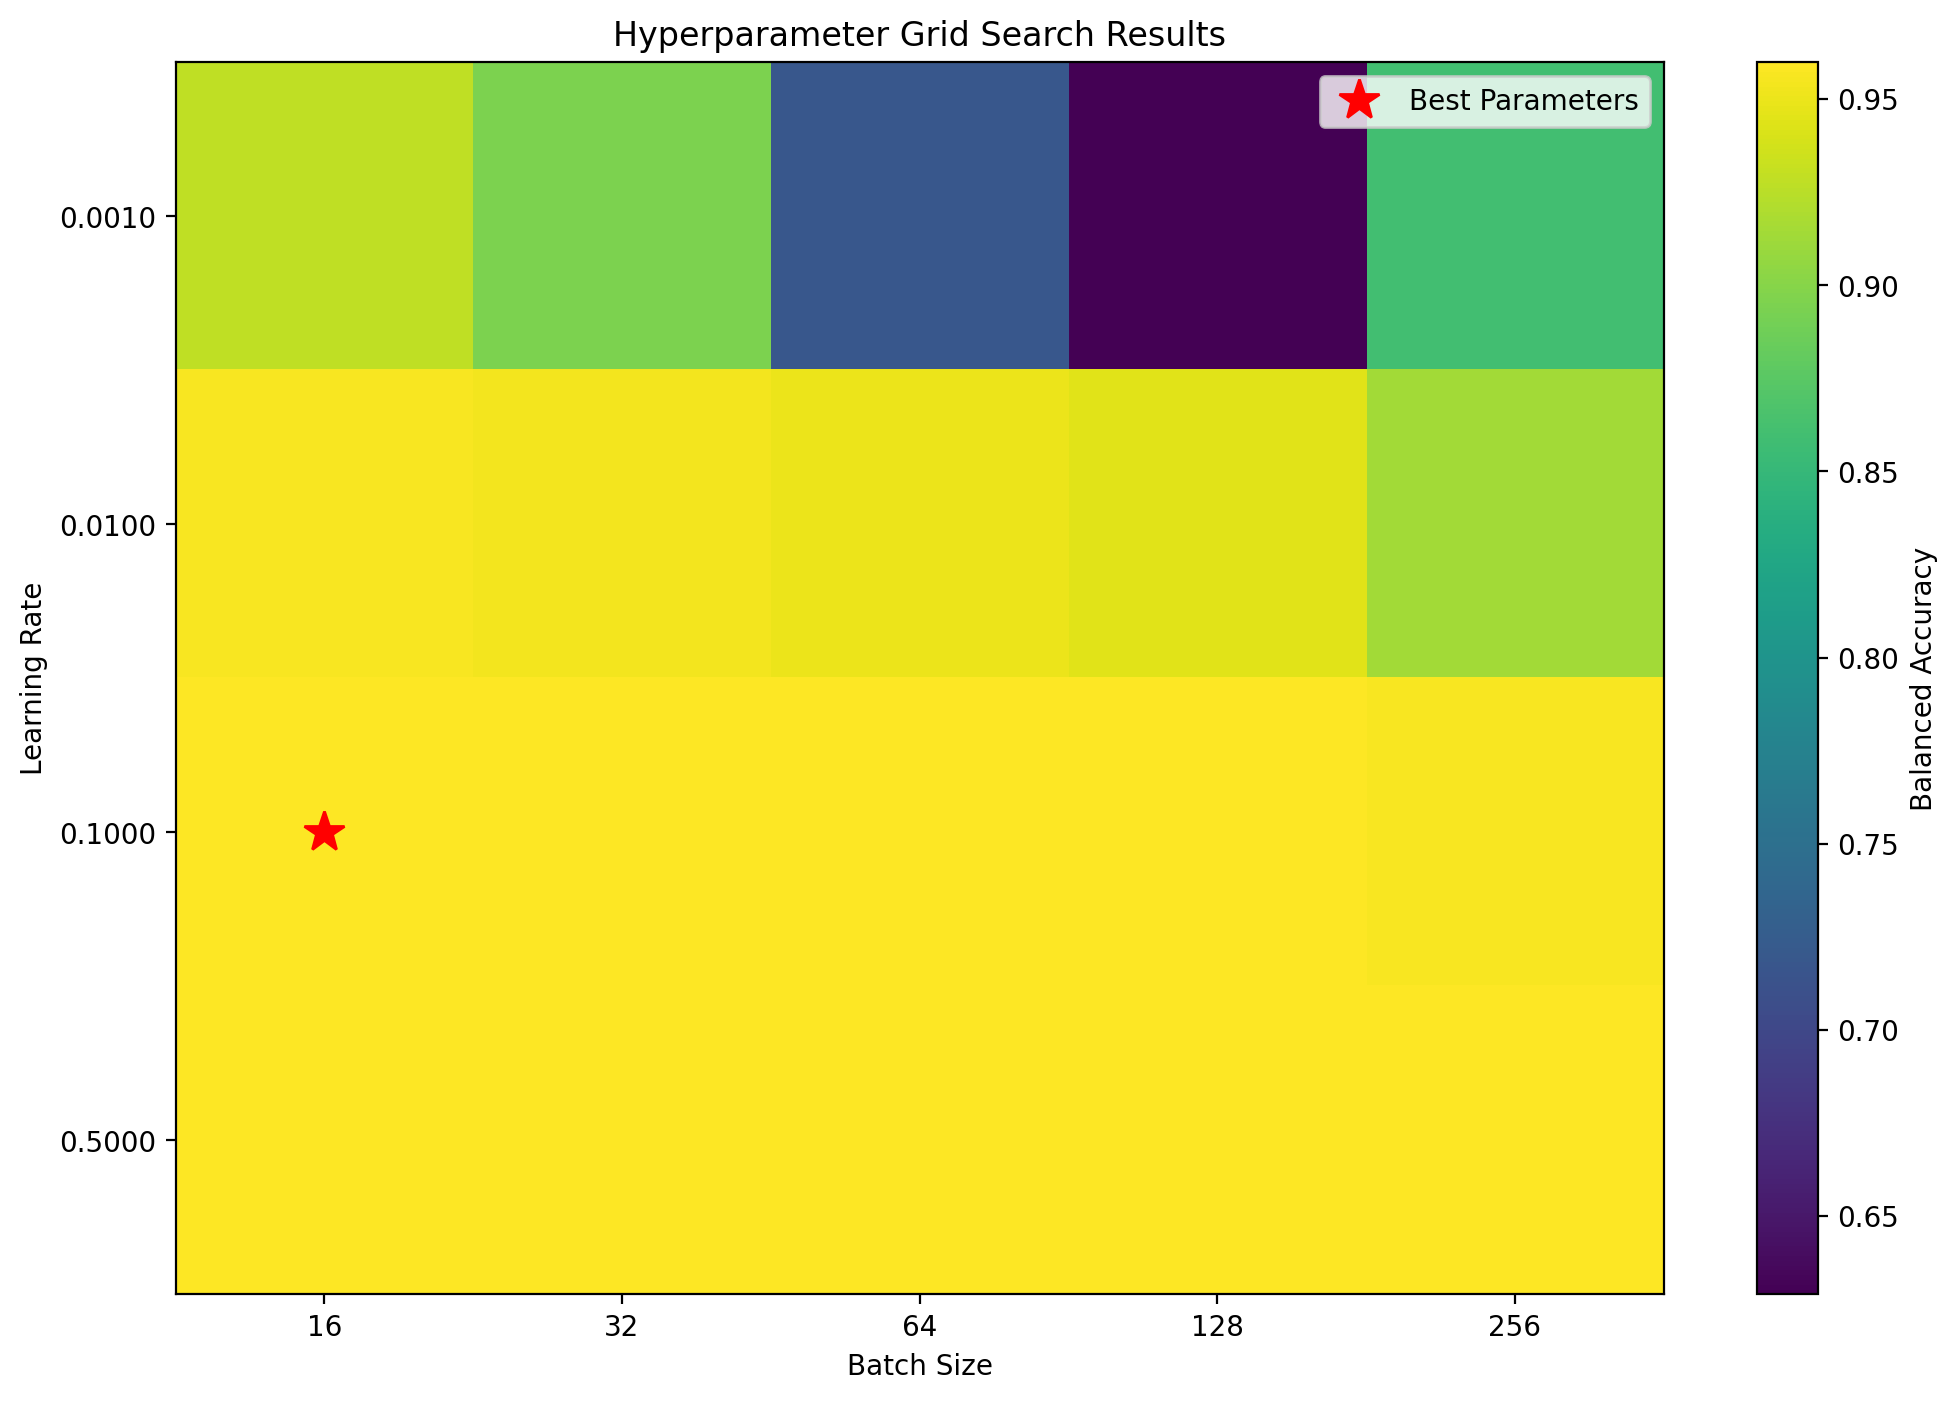

In [10]:
# Create heatmap of results
plt.figure(figsize=(12, 8))
acc_matrix = np.zeros((len(learning_rate_options), len(batch_size_options)))
for i, lr in enumerate(learning_rate_options):
    for j, batch_size in enumerate(batch_size_options):
        acc_matrix[i, j] = balanced_accuracy_results[(lr, batch_size)]

# Find indices of best parameters
best_i, best_j = np.unravel_index(np.argmax(acc_matrix), acc_matrix.shape)
best_params = (learning_rate_options[best_i], batch_size_options[best_j])
print(f"\nBest parameters found:")
print(f"lr = {best_params[0]}, batch_size = {best_params[1]}")
print(f"Best balanced accuracy: {np.max(acc_matrix):.3f}")

# Create subplot with heatmap
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(acc_matrix, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Balanced Accuracy')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Learning Rate')

# Set custom tick labels
ax.set_xticks(range(len(batch_size_options)))
ax.set_xticklabels(batch_size_options)
ax.set_yticks(range(len(learning_rate_options)))
ax.set_yticklabels([f"{x:.4f}" for x in learning_rate_options])

# Mark the best parameters on the plot
ax.plot(best_j, best_i, 'r*', markersize=15, label='Best Parameters')
ax.legend()

plt.title('Hyperparameter Grid Search Results')
plt.show()

Looking at the heatmap, we analyze how different hyperparameter combinations affect performance. Here are the key insights:

1.  **Impact of Learning Rate:**  The learning rate has a noticeable effect.  The best performance is clustered around a learning rate of 0.1.  A learning rate of 0.001 is likely too small, causing the model to learn very slowly and not reach a good solution within the given number of epochs.  Learning rates of 0.1 and 0.5 are likely too large, causing the optimization to overshoot the optimal solution and potentially oscillate or diverge.

2.  **Role of Batch Size:**  Smaller batch sizes (16 and 32) generally perform better than larger ones. This is consistent with the principle that the stochasticity introduced by smaller batches helps the model escape local minima and find a better overall solution.  However, the effect of batch size is less dramatic than that of the learning rate.

The optimal hyperparameters (Learning Rate = 0.1, Batch Size = 16) suggest a balance.  The learning rate of 0.01 allows the model to make reasonable progress in each iteration without overshooting. The small batch size of 16 introduces sufficient noise to help the optimization process explore the parameter space effectively.

With these insights, we train our final model using these optimized parameters.

## Final Model with Optimized Parameters

Now that we've found the best hyperparameters, let's train our final model using them:

Training final model with optimal hyperparameters...
Using lr=0.100000, batch_size=16
Epoch 0: Training Loss = 0.1645, Testing Loss = 0.1778
Epoch 20: Training Loss = 0.0853, Testing Loss = 0.0953
Epoch 40: Training Loss = 0.0848, Testing Loss = 0.0950
Epoch 60: Training Loss = 0.0849, Testing Loss = 0.0946
Epoch 80: Training Loss = 0.0848, Testing Loss = 0.0949
Epoch 100: Training Loss = 0.0848, Testing Loss = 0.0948
Epoch 120: Training Loss = 0.0848, Testing Loss = 0.0950
Epoch 140: Training Loss = 0.0848, Testing Loss = 0.0952
Epoch 160: Training Loss = 0.0848, Testing Loss = 0.0950
Epoch 180: Training Loss = 0.0848, Testing Loss = 0.0955
Epoch 200: Training Loss = 0.0848, Testing Loss = 0.0949
Epoch 220: Training Loss = 0.0848, Testing Loss = 0.0951
Epoch 240: Training Loss = 0.0848, Testing Loss = 0.0949
Epoch 260: Training Loss = 0.0848, Testing Loss = 0.0948
Epoch 280: Training Loss = 0.0848, Testing Loss = 0.0951


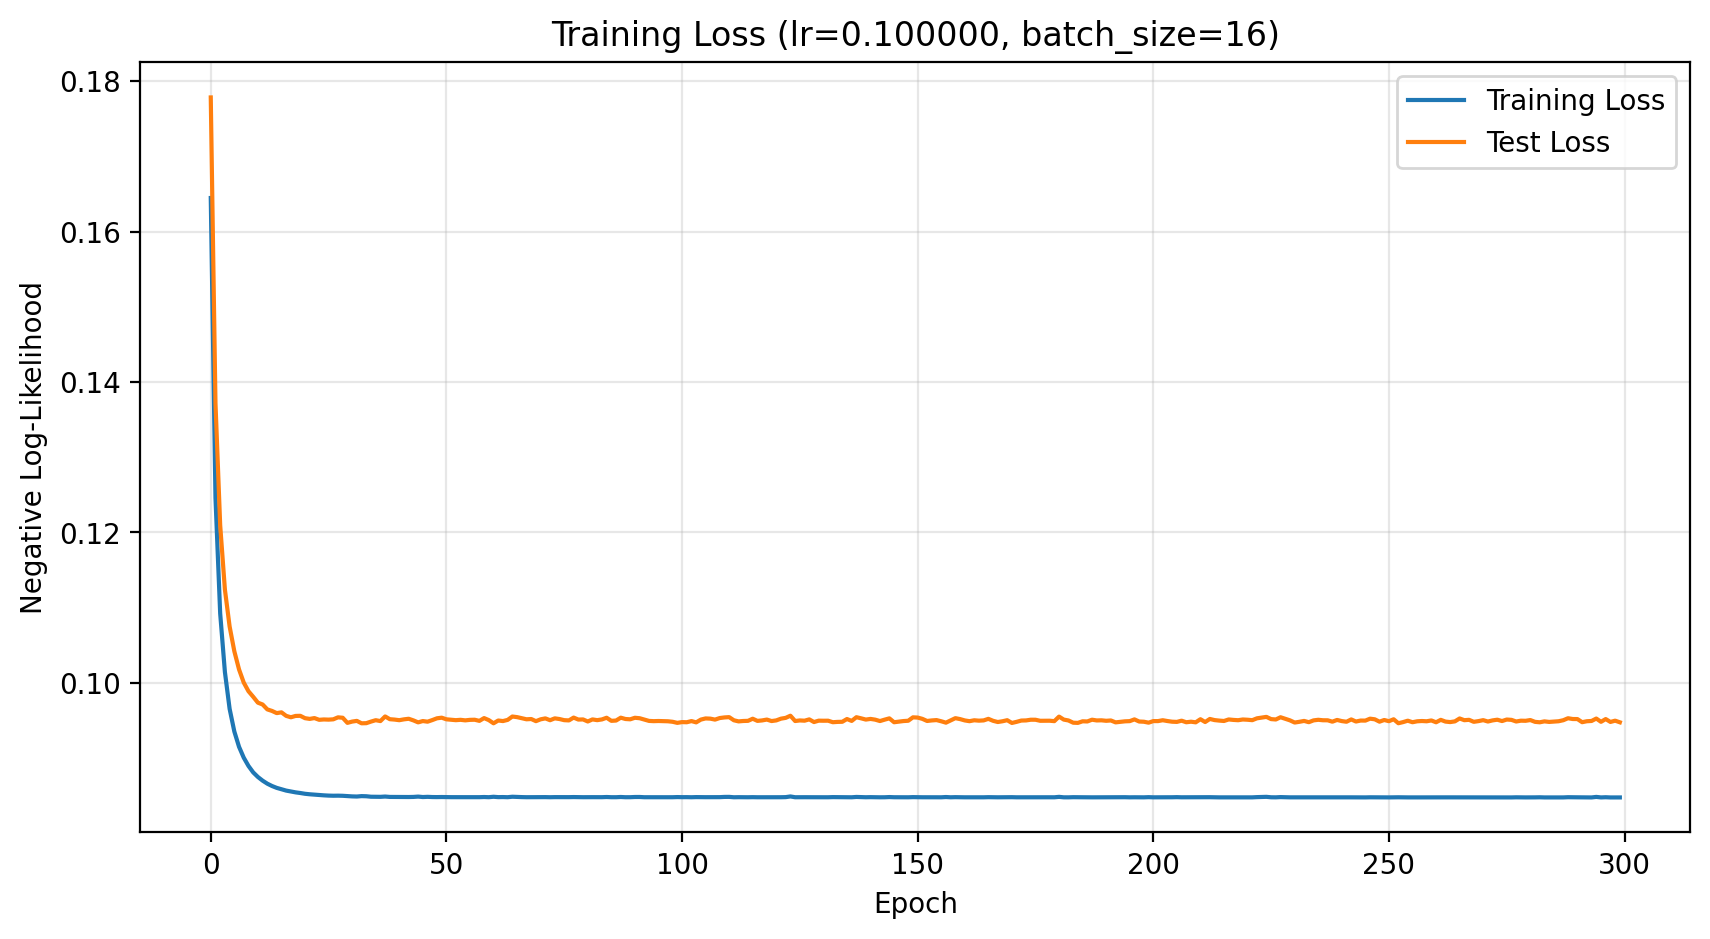

In [11]:
# Train final model with best hyperparameters
print("Training final model with optimal hyperparameters...")
print(f"Using lr={best_lr:.6f}, batch_size={best_batch_size}")
w_final, train_loss_history, test_loss_history = train(
    X_train, t_train, X_test, t_test, best_lr, 
    n_epochs=300, batch_size=best_batch_size, grad_func=grad
)  # Pass grad here
# Plot final training curve
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title(f'Training Loss (lr={best_lr:.6f}, batch_size={best_batch_size})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

We train the model with the best learning rate and batch size, and we plot the training loss to ensure it's still decreasing. We increased `n_epochs` slightly to give the optimized model more time to converge.

Now, let's re-evaluate the final model and visualize the prediction probabilities:

Final Model Performance:
Accuracy: 0.974
Balanced Accuracy: 0.960


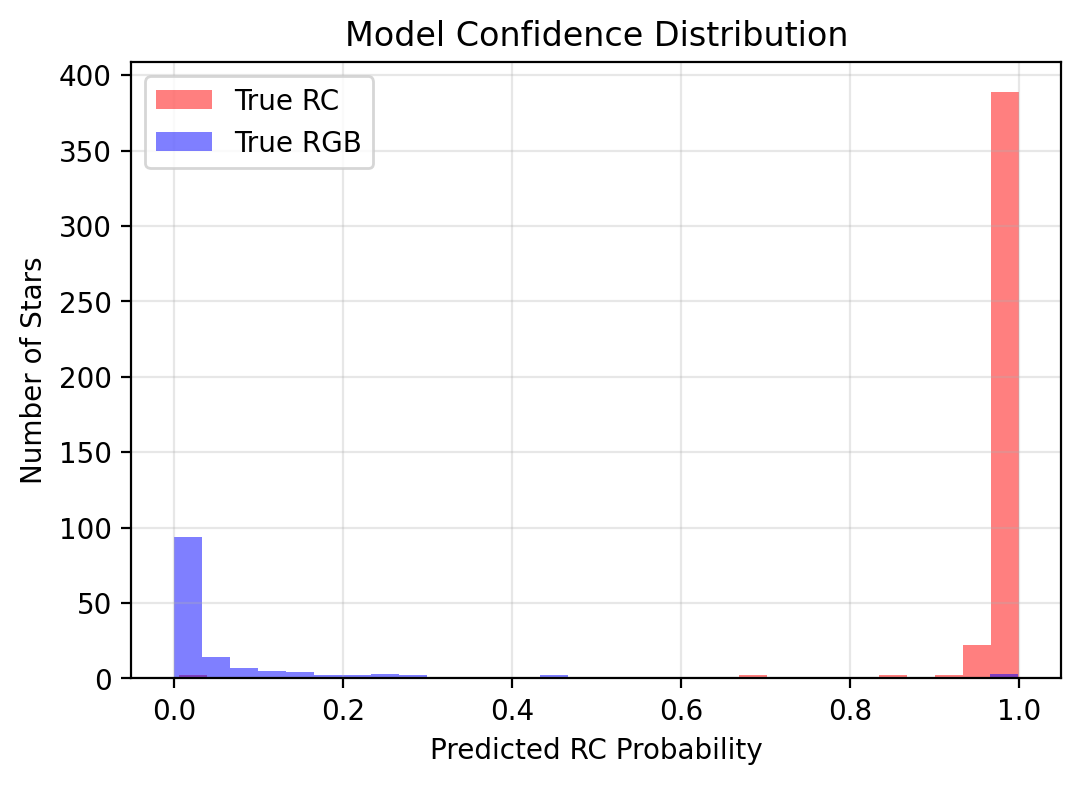

In [12]:
# Evaluate final model
test_pred, test_probs = predict(w_final, X_test)
final_metrics = compute_metrics(t_test, test_pred)

print("Final Model Performance:")
print(f"Accuracy: {final_metrics['accuracy']:.3f}")
print(f"Balanced Accuracy: {final_metrics['balanced_accuracy']:.3f}")

# Visualize prediction confidence
plt.hist(test_probs[t_test == 1], bins=30, alpha=0.5,
         label='True RC', color='red')
plt.hist(test_probs[t_test == 0], bins=30, alpha=0.5,
         label='True RGB', color='blue')
plt.xlabel('Predicted RC Probability')
plt.ylabel('Number of Stars')
plt.title('Model Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The histogram of predicted probabilities shows how confident the model is in its classifications.  Well-separated distributions indicate high confidence.

Let's visualize the decision boundary in the temperature-gravity plane, as before, but now with the final model:

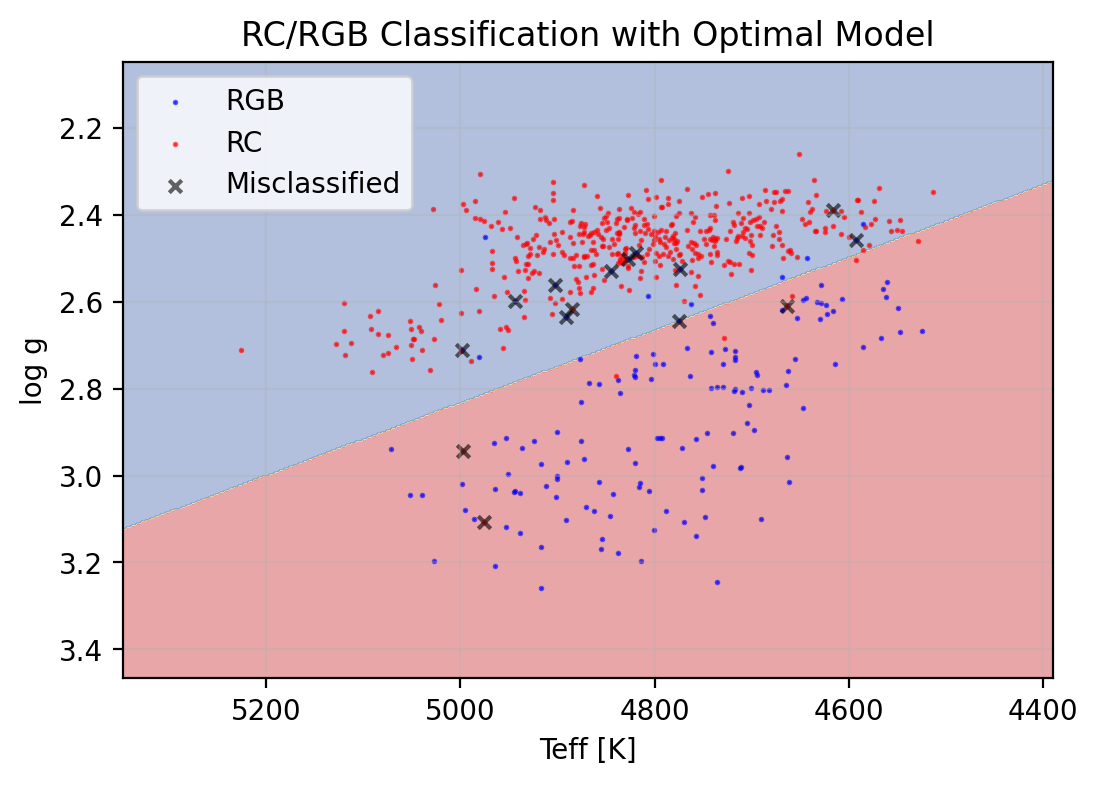

In [13]:
# Denormalize for physical interpretation
def denormalize(X_norm, mean, std):
    return X_norm * std + mean

# Create mesh grid in normalized space
teff_idx, logg_idx = 1, 2  # indices after adding bias term
x_min, x_max = X_test[:, teff_idx].min() - 1, X_test[:, teff_idx].max() + 1
y_min, y_max = X_test[:, logg_idx].min() - 1, X_test[:, logg_idx].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Prepare mesh points with median values for other features
X_mesh = np.ones((xx.ravel().shape[0], X_test.shape[1]))
X_mesh[:, teff_idx] = xx.ravel()
X_mesh[:, logg_idx] = yy.ravel()
for i in range(1, X_test.shape[1]):
    if i != teff_idx and i != logg_idx:
        X_mesh[:, i] = np.median(X_test[:, i])

# Get predictions
Z, _ = predict(w_final, X_mesh)
Z = Z.reshape(xx.shape)

# Get the original means and stds for denormalization
teff_mean, teff_std = X_mean[0], X_std[0]  # For Teff
logg_mean, logg_std = X_mean[1], X_std[1]  # For log g

# Denormalize the grid and data points for plotting
xx_denorm = xx * teff_std + teff_mean
yy_denorm = yy * logg_std + logg_mean
X_test_teff_denorm = X_test[:, teff_idx] * teff_std + teff_mean
X_test_logg_denorm = X_test[:, logg_idx] * logg_std + logg_mean

# Plot decision boundary and stars
plt.contourf(xx_denorm, yy_denorm, Z, alpha=0.4, cmap='RdYlBu')
plt.scatter(X_test_teff_denorm[t_test == 0], X_test_logg_denorm[t_test == 0],
           c='blue', s=1, alpha=0.6, label='RGB')
plt.scatter(X_test_teff_denorm[t_test == 1], X_test_logg_denorm[t_test == 1],
           c='red', s=1, alpha=0.6, label='RC')

# Mark misclassified points
misclassified = (test_pred != t_test).ravel()
plt.scatter(X_test_teff_denorm[misclassified], X_test_logg_denorm[misclassified],
           c='black', s=20, alpha=0.6, marker='x', label='Misclassified')

plt.xlabel('Teff [K]')
plt.ylabel('log g')
plt.title('RC/RGB Classification with Optimal Model')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

This code visualizes the decision boundary in the Teff-log g plane. The contour plot shows the regions where the model predicts RC (red) and RGB (blue). The points are the actual stars from the test set, colored according to their true labels. Misclassified stars are marked with black 'x's. Importantly, I've added code to denormalize the axes labels back to the original units (Kelvin and log g), making the plot directly interpretable in astrophysical terms.

## Understanding Feature Importance

Finally, let's examine which features the model found most important. Because we normalized the features, the magnitudes of the weights directly indicate feature importance:

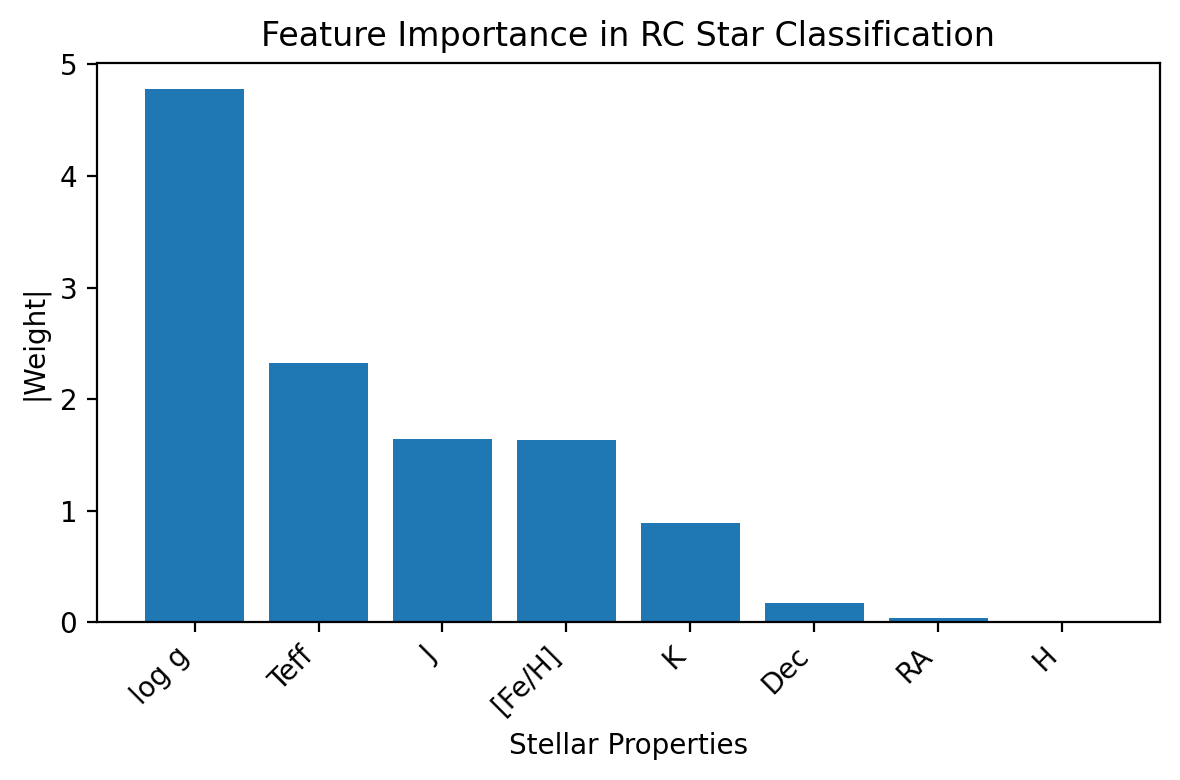


Feature Importance Analysis:
----------------------------------------
log g   : -4.7762
Teff    : +2.3260
J       : -1.6463
[Fe/H]  : +1.6346
K       : +0.8864
Dec     : +0.1727
RA      : -0.0440
H       : -0.0158


In [14]:
# Analyze feature importance with optimized model
feature_names = ['Bias', 'Teff', 'log g', '[Fe/H]', 'RA', 'Dec', 'J', 'H', 'K']
weights = w_final.ravel()  # Ensure 1D array

# Sort features by absolute weight value
importance = np.abs(weights[1:])  # Exclude bias
sorted_idx = np.argsort(importance)[::-1]

# Create feature importance plot
plt.bar(range(len(importance)), importance[sorted_idx])
plt.xticks(range(len(importance)),
          [feature_names[i+1] for i in sorted_idx],
          rotation=45, ha="right")  # Rotate labels for readability
plt.xlabel('Stellar Properties')
plt.ylabel('|Weight|')
plt.title('Feature Importance in RC Star Classification')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Print detailed feature analysis
print("\nFeature Importance Analysis:")
print("-" * 40)
for idx in sorted_idx:
    name = feature_names[idx+1]
    weight = weights[idx+1]
    print(f"{name:8s}: {weight:+.4f}")

Looking at the bar plot above, we can analyze how our model uses different stellar properties to make its classifications. The weights learned during training reveal a clear hierarchy of feature importance that aligns well with our astrophysical understanding:

1.  **Surface gravity (log g):** As expected, log g emerges as the most influential parameter. This makes perfect physical sense. RC stars have undergone the helium flash and settled into a specific, relatively narrow range of surface gravities. This distinguishes them from RGB stars, which are still ascending the giant branch and have lower, continuously changing surface gravities.

2.  **Effective temperature (Teff):**  Teff is the next most important feature. This also has a strong theoretical basis. RC stars are undergoing stable helium core burning, and this process occurs within a characteristic temperature range.

3.  **Metallicity ([Fe/H]):** Metallicity shows a moderate but notable influence. While not as crucial as the structural parameters (log g and Teff), a star's chemical composition does affect its evolution and its position on the HR diagram.  Including metallicity helps to refine the classification.

4.  **Positional Coordinates (RA, Dec) and Photometric Magnitudes (J, H, K):**  Interestingly, these features have relatively small weights. This is a very important result! It validates our model's physical understanding.  Whether a star is an RC star or not should depend on its intrinsic properties (log g, Teff, [Fe/H]), not on where we happen to observe it in the sky (RA, Dec) or how bright it appears to us (J, H, K magnitudes). The fact that the model has learned to largely ignore these features is a strong indication that it's learning the correct underlying physics.

This weight analysis demonstrates a key strength of logistic regression: its ability to learn physically meaningful patterns from data. The model's learned feature importances align beautifully with our theoretical expectations, providing valuable scientific insights.

## Conclusions

In this tutorial, we've built a complete logistic regression model for classifying Red Clump and Red Giant Branch stars. We covered:

-   Adapting linear models for classification using the sigmoid function.
-   Implementing mini-batch gradient descent from scratch.
-   Evaluating model performance using appropriate metrics (accuracy, balanced accuracy, confusion matrix).
-   Performing hyperparameter optimization (learning rate and batch size) using a grid search.
-   Interpreting model results, including visualizing the decision boundary and analyzing feature importance.

This example demonstrates how logistic regression can be a powerful and interpretable tool for astronomical classification problems. The learned weights provide insights into the physical properties that distinguish different types of stars.
